In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix

In [35]:
# ==========================================
# 1. DATA LOADING & ENHANCED FEATURES
# ==========================================
df = pd.read_csv('ircon.csv', parse_dates=['Datetime']).set_index('Datetime')

def engineer_features(data):
    data = data.copy()
    data['Ret_1h'] = data['Close'].pct_change()
    data['Rolling_Vol'] = data['Ret_1h'].rolling(20).std()
    
    # RSI & Momentum
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    data['RSI'] = 100 - (100 / (1 + (gain / loss)))
    
    # Trend & Volatility Indicators
    data['EMA_Diff'] = (data['Close'] - data['Close'].ewm(span=21).mean()) / data['Close'].ewm(span=21).mean()
    data['ATR'] = (data['High'] - data['Low']).rolling(14).mean()
    data['Vol_Z'] = (data['Volume'] - data['Volume'].rolling(20).mean()) / data['Volume'].rolling(20).std()
    
    # Target: 5-Day Directional Move
    data['Target'] = (data['Close'].shift(-35) > data['Close']).astype(int)
    return data.dropna()

df_model = engineer_features(df)
features = ['Ret_1h', 'Rolling_Vol', 'RSI', 'EMA_Diff', 'Vol_Z']

In [37]:
# ==========================================
# 2. PROFIT-BOOSTED ENSEMBLE (Soft Voting)
# ==========================================
X, y = df_model[features], df_model['Target']
signals = np.zeros(len(df_model))
accuracies = np.zeros(len(df_model))

train_win = 100
for i in range(train_win, len(df_model)):
    X_train, y_train = X.iloc[i-train_win:i], y.iloc[i-train_win:i]
    sc = StandardScaler()
    X_train_sc = sc.fit_transform(X_train)
    X_curr_sc = sc.transform(X.iloc[i:i+1])
    
    rf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42).fit(X_train_sc, y_train)
    lr = LogisticRegression().fit(X_train_sc, y_train)
    
    # Profit Boosting: Looser threshold (0.52) to increase trade frequency
    avg_prob = (rf.predict_proba(X_curr_sc)[0][1] + lr.predict_proba(X_curr_sc)[0][1]) / 2
    signals[i] = 1 if avg_prob > 0.52 else (0 if avg_prob < 0.48 else 0.5)
    
    if i > train_win:
        accuracies[i] = 1 if (signals[i-1] == y.iloc[i-1]) else 0

df_model['Signal'] = signals
df_model['Rolling_Acc'] = pd.Series(accuracies).rolling(30).mean().values

In [38]:
# ==========================================
# 3. CAPITAL SIMULATION & TRADE JOURNAL 
# ==========================================
initial_capital = 100000.0
capital = initial_capital
risk_per_trade = 0.05  # 5% Risk per trade
equity = [initial_capital] * len(df_model)
trade_logs = []

# Detect Entry and Exit for Journaling
for i in range(train_win, len(df_model)):
    sig = df_model['Signal'].iloc[i-1]
    ret = df_model['Ret_1h'].iloc[i]
    price = df_model['Close'].iloc[i]
    
    # Position weight (Volatility-Adjusted)
    weight = risk_per_trade / (df_model['Rolling_Vol'].iloc[i] * 10)
    weight = min(weight, 1.2) # Allow slight leverage
    
    action = 1 if sig == 1 else (-1 if sig == 0 else 0)
    pnl = capital * weight * action * ret
    capital += pnl
    equity[i] = capital
    
    # Logging Logic: Capture every non-zero action
    if action != 0:
        trade_logs.append({
            'Timestamp': df_model.index[i],
            'Type': 'LONG' if action == 1 else 'SHORT',
            'Weight': f"{weight:.2%}",
            'Execution_Price': round(price, 2),
            'Hourly_PnL': round(pnl, 2),
            'Account_Balance': round(capital, 2)
        })

df_model['Equity'] = equity
df_model['Strat_Ret'] = df_model['Equity'].pct_change().fillna(0)
df_journal = pd.DataFrame(trade_logs)
df_journal.to_csv('trade_journal.csv', index=False)

In [39]:
# ==========================================
# 4. RESULTS CONSOLE OUTPUT 
# ==========================================
def get_metrics(returns, equity_curve):
    sharpe = (returns.mean() / returns.std()) * np.sqrt(252*7) if returns.std() != 0 else 0
    drawdown = (equity_curve / equity_curve.expanding().max() - 1).min()
    total_ret = (equity_curve.iloc[-1] / equity_curve.iloc[0] - 1)
    return total_ret, sharpe, drawdown

total_ret, sharpe, max_dd = get_metrics(df_model['Strat_Ret'], df_model['Equity'])

print("\n" + "="*40)
print("EVALUATION RESULTS")
print("="*40)
print(f"Final Capital:      ₹{capital:,.2f}")
print(f"Total Return:       {total_ret:.2%}")
print(f"Annualized Sharpe:  {sharpe:.2f}")
print(f"Maximum Drawdown:   {max_dd:.2%}")
print(f"Signal Accuracy:    {accuracy_score(df_model['Target'], df_model['Signal'].round()):.2%}")
print(f"Trade Journal:      'trade_journal.csv' generated with {len(df_journal)} entries.")
print("="*40 + "\n")


EVALUATION RESULTS
Final Capital:      ₹111,728.71
Total Return:       11.73%
Annualized Sharpe:  4.56
Maximum Drawdown:   -3.66%
Signal Accuracy:    70.77%
Trade Journal:      'trade_journal.csv' generated with 152 entries.



C:\Users\Maanvik\AppData\Local\Temp\ipykernel_21776\2889287260.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_journal, x='Type', palette='viridis', ax=ax4)


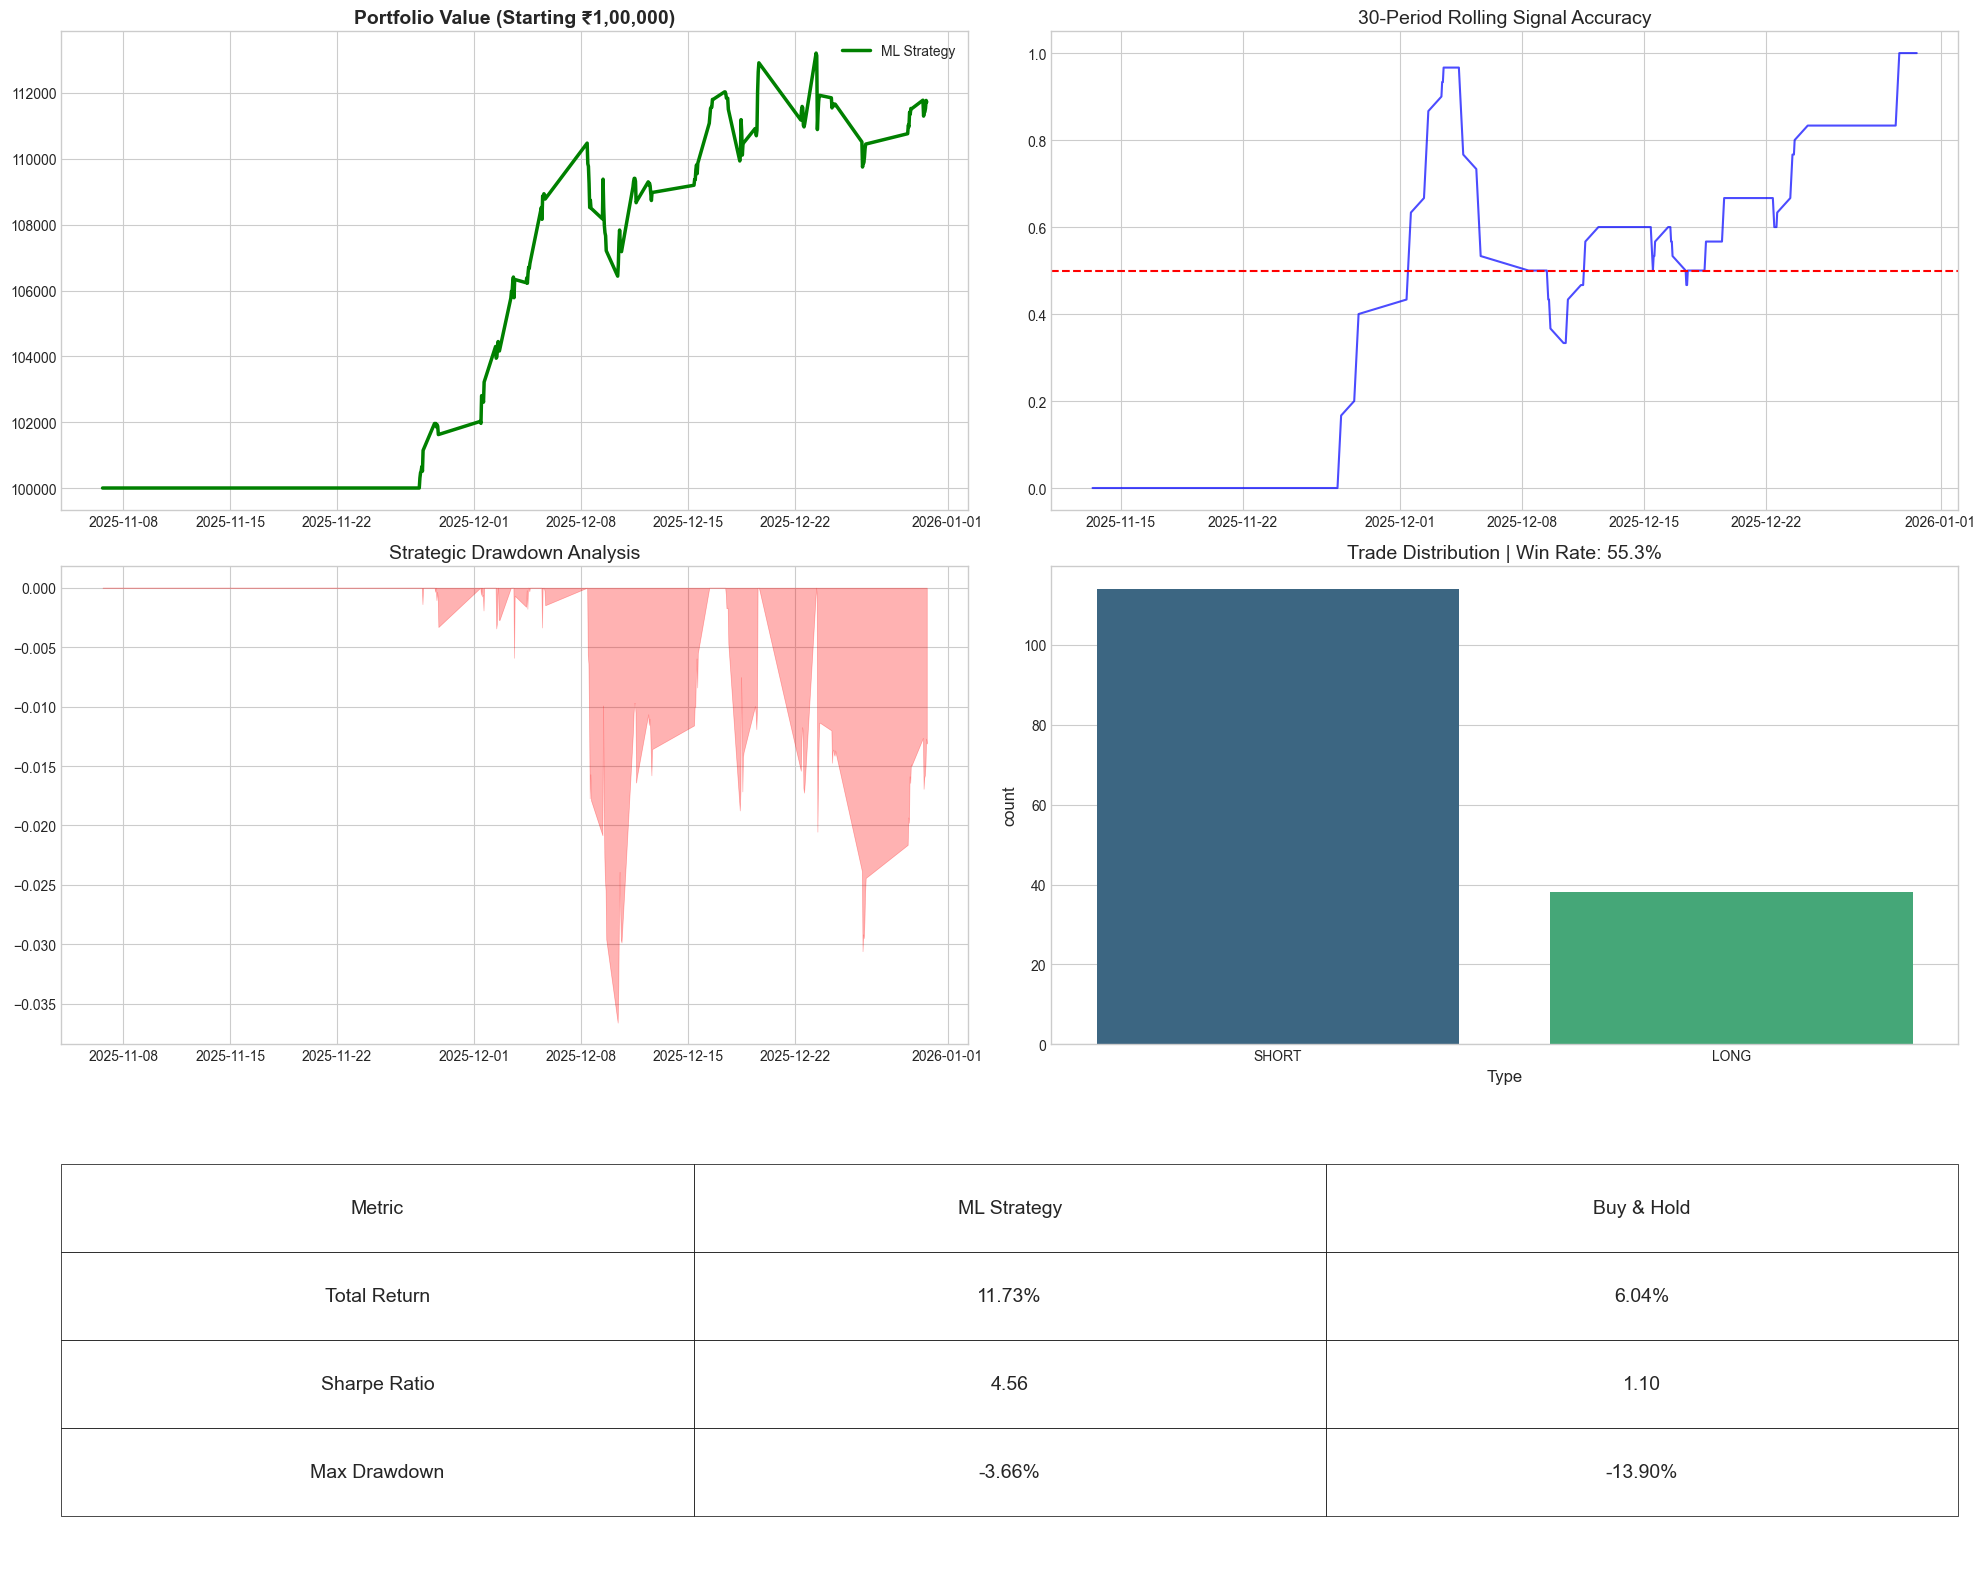

In [40]:
# ==========================================
# 5. DASHBOARD VISUALS
# ==========================================
plt.style.use('seaborn-v0_8-whitegrid')
fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(3, 2)

# Plot 1: Equity Curve
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(df_model['Equity'], color='green', lw=2.5, label='ML Strategy')
ax1.set_title('Portfolio Value (Starting ₹1,00,000)', fontsize=14, fontweight='bold')
ax1.legend()

# Plot 2: Rolling Accuracy
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(df_model['Rolling_Acc'], color='blue', alpha=0.7)
ax2.axhline(0.5, ls='--', color='red')
ax2.set_title('30-Period Rolling Signal Accuracy', fontsize=14)

# Plot 3: Drawdown Analysis
ax3 = fig.add_subplot(gs[1, 0])
dd_curve = (df_model['Equity'] / df_model['Equity'].expanding().max() - 1)
ax3.fill_between(dd_curve.index, dd_curve, 0, color='red', alpha=0.3)
ax3.set_title('Strategic Drawdown Analysis', fontsize=14)

# Plot 4: Trade Distribution
ax4 = fig.add_subplot(gs[1, 1])
win_rate = (df_journal['Hourly_PnL'] > 0).mean() if not df_journal.empty else 0
sns.countplot(data=df_journal, x='Type', palette='viridis', ax=ax4)
ax4.set_title(f'Trade Distribution | Win Rate: {win_rate:.1%}', fontsize=14)

# Plot 5: Benchmark Table
ax5 = fig.add_subplot(gs[2, :])
ax5.axis('off')
metrics_data = [
    ['Total Return', f"{total_ret:.2%}", f"{(df_model['Ret_1h'].cumsum().iloc[-1]):.2%}"],
    ['Sharpe Ratio', f"{sharpe:.2f}", f"{(df_model['Ret_1h'].mean()/df_model['Ret_1h'].std()*np.sqrt(252*7)):.2f}"],
    ['Max Drawdown', f"{max_dd:.2%}", f"{(df_model['Close']/df_model['Close'].expanding().max()-1).min():.2%}"]
]
table = ax5.table(cellText=metrics_data, colLabels=['Metric', 'ML Strategy', 'Buy & Hold'], loc='center', cellLoc='center')
table.set_fontsize(14)
table.scale(1, 4)

plt.tight_layout()
plt.show()